### Required software

The following packages were used in this analysis:

In [1]:
with open("requirements.txt", "r") as handle:
    print(handle.read())

bcbio-gff==0.6.2
biopython==1.65
certifi==2015.4.28
ipython==3.1.0
Jinja2==2.7.3
json-schema==0.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.3
mistune==0.5.1
nose==1.3.6
numpy==1.9.2
pandas==0.16.0
Pillow==2.8.1
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.3
python-dateutil==2.4.2
pytz==2015.2
pyzmq==14.6.0
reportlab==3.1.44
scipy==0.15.1
six==1.9.0
terminado==0.5
tornado==4.1



To run this notebook for yourself create a new [virtual environment](https://virtualenv.pypa.io/en/latest/) in the prompt:

```
$ virtualenv env
$ source env/bin/activate
$ pip install numpy
$ pip install -r requirements
```

Then to run the notebook itself:

```
$ ipython notebook
```

In [2]:
%matplotlib inline

In [3]:
from collections import defaultdict
import os
from os.path import join as pjoin
import subprocess
import re

from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.Graphics.GenomeDiagram import CrossLink
from Bio.Blast.Applications import NcbirpstblastnCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast.Applications import NcbipsiblastCommandline
from Bio.SeqFeature import SeqFeature
from Bio.SeqFeature import FeatureLocation
from reportlab.lib import colors
from reportlab.lib.units import cm
from BCBio import GFF
from IPython.display import SVG
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [4]:
pd.set_option("display.max_colwidth", 800)
pd.options.display.max_rows = 999
THREADS = 2  # Number of CPUs available for calls to BLAST etc.

In [5]:
STEPS = [
    'data',
    "01-genomic_regions",
    "02-found_distribution_of_scaffold_length",
    "03-place_candidate_scaffold_lengths_distribution",
    "04-found_length_distribution_of_scaffolds_with_genes",
    "05-place_candidate_scaffold_lengths_distribution_gene_contiaining",
    ]

for step in STEPS:
    if not os.path.isdir(step):
        os.mkdir(step)

## Candidates

Jason identified 10 candidate _AvrRvi5_ genes.
Nine were discovered by comparative genomics, and 1 was discovered by comparative transcriptomics of 14 day old _Venturia inaequalis_ cultures in potato dextrose broth \(PDB\).
`atg10719` was the candidate identified by the transcriptomics method, it is expressed in MNH120 but not in Race 5.

Below is a summary dataframe of the candidates:

In [6]:
CANDIDATES = pd.read_csv(pjoin(STEPS[0], "summary.DNA-seq.RNA-seq.csv"))
CANDIDATES

,method,gene,aa_mutation,length,gb_acc,blast_desc,organism,evalue,identity
0,DNA-seq,atg161,T184I,237,No hit,NaN,NaN,NaN,NaN
1,DNA-seq,atg162,T417A,459,WP_030543571.1,Hypothetical protein,Streptomyces albus,0.000000008,29
2,DNA-seq,atg4020,"P174PNAKPDAKPDAKPDAKP, V155L",185,XP_007283047.1,Snoal-like polyketide cyclase family protein,Colletotrichum gloeosporioides,3E-029,40.15
3,DNA-seq,atg12487,V388M,403,ADT70774.1,Cellobiose dehydrogenase,Dichomera saubinetii,7E-013,55.56
4,DNA-seq,atg140* (not original gene call) first 15 amino acids removed,D83N,232,No hit,NaN,NaN,NaN,NaN
5,DNA-seq,atg7465,V463I,626,EKG19035.1,Glycoside hydrolase family 1,Macrophomina phaesolina,0,75.36
6,DNA-seq,atg10724,"K178N,K239R",292,No hit,NaN,NaN,NaN,NaN
7,DNA-seq,atg10703,G102A,202,No hit,NaN,NaN,NaN,NaN
8,DNA-seq,atg4290,L423S,436,XP_007795436.1,putative chloroperoxidase-like protein [Eutypa lata UCREL1],Eutypa lata,1E-022,38
9,RNA-seq,atg10719,Not expressed in race 5,86,No hit,No hit,No hit,No hit,No hit


In [7]:
CANDIDATES.loc[4,'gene'] = 'atg140'

In [8]:
GENOME_FILES = {
    'MNH120': {
        'fasta': pjoin(STEPS[0], 'MNH120.genome.masked.fasta'),
        'gff': [
            pjoin(STEPS[0], 'augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3'),
            pjoin(STEPS[0], 'MNH120.REPET_TEs.gff3'),
            pjoin(STEPS[0], 'MNH120.REPET_SSRs.gff3'),
            ]
        },
    'B04': {
        'fasta': pjoin(STEPS[0], 'B04.genome.fa'),
        'gff': [
            pjoin(STEPS[0], 'B04.genes.gff3'),
            ]
        },
    'I5V': {
        'fasta': pjoin(STEPS[0], 'I5V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I5V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I9A': {
        'fasta': pjoin(STEPS[0], 'I9A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I9A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I17V': {
        'fasta': pjoin(STEPS[0], 'I17V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I17V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I19A': {
        'fasta': pjoin(STEPS[0], 'I19A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I19A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I31A': {
        'fasta': pjoin(STEPS[0], 'I31A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I31A.gapfilled.final.cleaned.gff3'),
            ],
        },
    'I37A': {
        'fasta': pjoin(STEPS[0], 'I37A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I37A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I61A': {
        'fasta': pjoin(STEPS[0], 'I61A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I61A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I67V': {
        'fasta': pjoin(STEPS[0], 'I65V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I65V.PredictedPass.cleaned.gff3'),
            ],
        }
    }

In [9]:
GENOMES = dict()
for isolate, files in GENOME_FILES.items():
    GENOMES[isolate] = SeqIO.to_dict(
        SeqIO.parse(files['fasta'], format="fasta")
        )

    for gff in files['gff']:
        genome_with_features = GFF.parse(
            gff,
            base_dict=GENOMES[isolate]
            )
        GENOMES[isolate].update(SeqIO.to_dict(genome_with_features))

In [10]:
GENES = dict()
GENES['MNH120'] = SeqIO.to_dict(
    SeqIO.parse(pjoin(STEPS[0], 'MNH120.Auto.genes.fna'), format="fasta")
    )

In [11]:
BLASTDBS = dict()
for isolate, files in GENOME_FILES.items():
    command = [
        "makeblastdb",
        "-in", files['fasta'],
        "-input_type", "fasta",
        "-dbtype", "nucl",
        "-title", isolate,
        "-parse_seqids",
        "-taxid", "5025",
        "-out", pjoin(STEPS[0], isolate)
        ]
    subps = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
        )
    stdout, stderr = subps.communicate()
    BLASTDBS[isolate] = pjoin(STEPS[0], isolate)

command = [
    "blastdb_aliastool",
    "-dblist", " ".join([v for k, v in BLASTDBS.items()]),
    "-dbtype", "nucl",
    "-title", 'combined',
    "-out", pjoin(STEPS[0], 'combined')
    ]
subps = subprocess.Popen(
    command,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
    )
stdout, stderr = subps.communicate()
BLASTDBS['combined'] = pjoin(STEPS[0], 'combined')

### Step 01 - found candidates in all genomes

In [12]:
candidate_sequences= list()
for candidate in CANDIDATES['gene']:
    candidate_sequences.append(GENES['MNH120'][candidate])

filename = pjoin(STEPS[1], 'candidate_sequences.fasta')
SeqIO.write(candidate_sequences, filename, 'fasta')

10

In [13]:
template = '''\
'''

output_columns = [
    "qseqid",
    "sseqid",
    "qstart",
    "qend",
    "sstart",
    "send",
    "evalue",
    "bitscore",
    "length",
    "pident",
    "sstrand",
    ]
filename = pjoin(STEPS[1], 'candidates_blast_against_all.csv')
blastn_cline = NcbiblastnCommandline(
    query=pjoin(STEPS[1], 'candidate_sequences.fasta'),
    db=BLASTDBS['combined'],
    out=filename,
    outfmt='"6 ' + " ".join(output_columns) + '"',
    evalue=0.1,
    num_threads=THREADS
    )
print(blastn_cline)

stdout, stderr = blastn_cline()
print(stdout)
print(stderr)

with open(filename + '.txt', 'w') as handle:
    handle.write(template)

blastn -out 01-genomic_regions/candidates_blast_against_all.csv -outfmt "6 qseqid sseqid qstart qend sstart send evalue bitscore length pident sstrand" -query 01-genomic_regions/candidate_sequences.fasta -db data/combined -evalue 0.1 -num_threads 2




In [14]:
scaf_to_isolate = dict()
for isolate, genome in GENOMES.items():
    for scaffold in genome:
        if scaffold in scaf_to_isolate:
            raise
        scaf_to_isolate[scaffold] = isolate

output_columns = [
    "qseqid",
    "sseqid",
    "qstart",
    "qend",
    "sstart",
    "send",
    "evalue",
    "bitscore",
    "length",
    "pident",
    "sstrand",
    ]

blastn_results = pd.read_table(
    pjoin(STEPS[1], 'candidates_blast_against_all.csv'),
    sep="\t",
    header=None,
    names=output_columns
    )

isolate_column = list()
for i, row in blastn_results.iterrows():
    scaffold = row['sseqid']
    isolate_column.append(scaf_to_isolate[scaffold])

blastn_results.insert(1, 'isolate', pd.Series(isolate_column))
blastn_results.to_csv(
    pjoin(STEPS[1], 'candidates_blast_against_all_with_isolates.csv'),
    sep='\t',
    encoding='utf-8',
    index=False,
    header=True
    )

blastn_results

,qseqid,isolate,sseqid,qstart,qend,sstart,send,evalue,bitscore,length,pident,sstrand
0,atg161,MNH120,scaffold_48,348,711,5820,5457,0.000000e+00,673.0,364,100.00,minus
1,atg161,MNH120,scaffold_48,71,347,6152,5876,2.000000e-143,512.0,277,100.00,minus
2,atg161,MNH120,scaffold_48,1,70,6270,6201,3.000000e-28,130.0,70,100.00,minus
3,atg161,I9A,NODE_17114_length_106818_cov_13.533281,348,711,66524,66161,0.000000e+00,673.0,364,100.00,minus
4,atg161,I9A,NODE_17114_length_106818_cov_13.533281,71,347,66856,66580,2.000000e-143,512.0,277,100.00,minus
5,atg161,I9A,NODE_17114_length_106818_cov_13.533281,1,70,66974,66905,3.000000e-28,130.0,70,100.00,minus
6,atg161,I61A,NODE_9417_length_112597_cov_9.223985,348,711,34213,33850,0.000000e+00,673.0,364,100.00,minus
7,atg161,I61A,NODE_9417_length_112597_cov_9.223985,71,347,34545,34269,2.000000e-143,512.0,277,100.00,minus
8,atg161,I61A,NODE_9417_length_112597_cov_9.223985,1,70,34663,34594,3.000000e-28,130.0,70,100.00,minus
9,atg161,I37A,NODE_28325_length_1062677_cov_11.556614,348,711,1007287,1006924,0.000000e+00,673.0,364,100.00,minus


### Step 02 - found distribution of scaffold length

In [15]:
scaffold_lengths = list()

for isolate, genome in GENOMES.items():
    for scaffold, sequence in genome.items():
        row = {
            'isolate': isolate,
            'scaffold': scaffold,
            'length': len(sequence)
            }
        scaffold_lengths.append(row)

scaffold_lengths = pd.DataFrame(scaffold_lengths)
scaffold_lengths.to_csv(
    pjoin(STEPS[2], 'scaffold_lengths.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

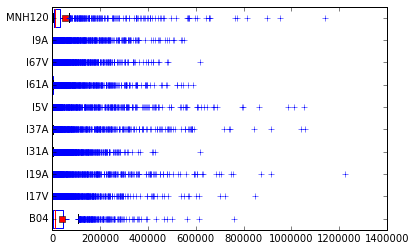

In [16]:
isolate_names = list()
isolate_lengths = list()
for i, j in scaffold_lengths.groupby(['isolate'])['length']:
    isolate_names.append(i)
    isolate_lengths.append(j.values)
fig, ax = plt.subplots()
dummy = ax.boxplot(isolate_lengths, labels=isolate_names, vert=False, showmeans=True, widths=0.8)

In [17]:
#scaffold_lengths.groupby('isolate').describe()

### Step 03 - place candidate scaffold lengths in distribution

In [18]:
blastn_results = pd.read_csv(
    pjoin(STEPS[1], 'candidates_blast_against_all_with_isolates.csv'),
    sep='\t'
    )
scaffold_lengths = pd.read_csv(
    pjoin(pjoin(STEPS[2], 'scaffold_lengths.csv')),
    sep='\t'
    )
for (isolate, candidate), tab in blastn_results.groupby(['isolate', 'qseqid']):
    scaffolds = set(tab['sseqid'])
    view = scaffold_lengths[scaffold_lengths['isolate'] == isolate]
    for scaffold in scaffolds:
        idx = view['scaffold'][
            view['scaffold'] == scaffold
            ].index.values[0]
        print(candidate, scaffold, len(GENOMES[isolate][scaffold]), view['length'].rank(pct=True)[idx])

atg10703 B04S209 99402 0.851590106007
atg10719 B04S157 123650 0.889045936396
atg10719 B04S209 99402 0.851590106007
atg10719 B04S27 273355 0.980918727915
atg10724 B04S209 99402 0.851590106007
atg12487 B04S84 173445 0.940636042403
atg140 B04S32 256617 0.977385159011
atg140 B04S100 161523 0.929328621908
atg140 B04S196 104567 0.86148409894
atg140 B04S1 758575 1.0
atg161 B04S209 99402 0.851590106007
atg162 B04S209 99402 0.851590106007
atg4020 B04S181 112942 0.872084805654
atg4290 B04S185 111428 0.86925795053
atg7465 B04S209 99402 0.851590106007
atg10703 NODE_17153_length_617906_cov_9.525179 615942 0.999562427071
atg10719 NODE_20564_length_34275_cov_8.589526 34250 0.926633605601
atg10719 NODE_17153_length_617906_cov_9.525179 615942 0.999562427071
atg10724 NODE_17153_length_617906_cov_9.525179 615942 0.999562427071
atg12487 NODE_17153_length_617906_cov_9.525179 615942 0.999562427071
atg140 NODE_46667_length_291164_cov_9.505976 290198 0.995332555426
atg140 NODE_44578_length_89411_cov_8.941226 

### Step 04 - looking again only at scaffolds with genes

In [19]:
scaffold_lengths_genes = list()

for isolate, genome in GENOMES.items():
    for scaffold, sequence in genome.items():
        if len([f for f in sequence.features if f.type == 'gene']) == 0:
            continue
        row = {
            'isolate': isolate,
            'scaffold': scaffold,
            'length': len(sequence)
            }
        scaffold_lengths_genes.append(row)

scaffold_lengths_genes = pd.DataFrame(scaffold_lengths_genes)
scaffold_lengths_genes.to_csv(
    pjoin(STEPS[4], 'scaffold_lengths_containing_genes.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

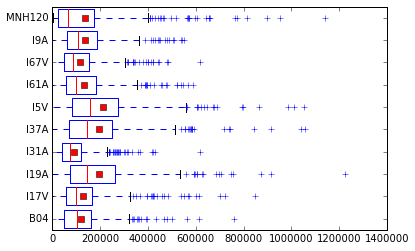

In [20]:
isolate_names = list()
isolate_lengths = list()
for i, j in scaffold_lengths_genes.groupby(['isolate'])['length']:
    isolate_names.append(i)
    isolate_lengths.append(j.values)
fig, ax = plt.subplots()
dummy = ax.boxplot(isolate_lengths, labels=isolate_names, vert=False, showmeans=True, widths=0.8)

In [21]:
#scaffold_lengths.groupby('isolate').describe()

### Step 05 - Place candidate scaffold length in distribution of gene containing scaffold lengths 

In [29]:
blastn_results = pd.read_csv(
    pjoin(STEPS[1], 'candidates_blast_against_all_with_isolates.csv'),
    sep='\t'
    )
scaffold_lengths_genes = pd.read_csv(
    pjoin(pjoin(STEPS[4], 'scaffold_lengths_containing_genes.csv')),
    sep='\t'
    )
positions = defaultdict(lambda: defaultdict(list))
for (isolate, candidate), tab in blastn_results.groupby(['isolate', 'qseqid']):
    scaffolds = set(tab['sseqid'])
    
    view = scaffold_lengths_genes[scaffold_lengths_genes['isolate'] == isolate]
    for scaffold in scaffolds:
        idx = view['scaffold'][
            view['scaffold'] == scaffold
            ].index.values[0]
        positions[candidate][isolate].append(view['length'].rank(pct=True)[idx])
        #print(candidate, scaffold, len(GENOMES[isolate][scaffold]), view['length'].rank(pct=True)[idx])

In [36]:
for candidate, isolates in positions.items():
    print("\n", candidate)
    for isolate, pos in isolates.items():
        print("{:>8}:".format(isolate), ', '.join([str(i) for i in pos]))


 atg10719
    I67V: 0.911578947368, 0.905263157895, 0.113684210526
  MNH120: 0.69476744186, 0.994186046512, 0.979651162791
     I9A: 0.770883054893, 0.501193317422
    I19A: 0.9375, 0.319078947368, 0.203947368421
    I31A: 0.297520661157, 0.78347107438
    I61A: 0.928741092637, 0.147268408551, 0.850356294537
     I5V: 0.793220338983, 0.0338983050847
    I17V: 0.125284738041, 0.993166287016
     B04: 0.611528822055, 0.483709273183, 0.932330827068
    I37A: 1.0, 0.632075471698

 atg12487
    I67V: 0.964210526316
  MNH120: 0.976744186047
     I9A: 0.825775656325
    I19A: 0.703947368421
    I31A: 0.717355371901
    I61A: 0.8432304038
     I5V: 0.691525423729
    I17V: 0.993166287016
     B04: 0.789473684211
    I37A: 0.801886792453

 atg162
    I67V: 0.964210526316
  MNH120: 0.494186046512
     I9A: 0.494033412888
    I19A: 0.509868421053
    I31A: 0.472727272727
    I61A: 0.543942992874
     I5V: 0.691525423729
    I17V: 0.993166287016
     B04: 0.483709273183
    I37A: 1.0

 atg140
   